# Tarea 2
## Laboratorio de Datos

# 1 Carga y transformación de Datos

In [3]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1597_bacteria_4192.jpeg  
  inflating: chest_xr

In [4]:
# librerías usadas
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage import io
from skimage.color import gray2rgb

# 1
# iniciar datos

"""
Funciones loaders 
- pil_loader        :   carga con pil
- skimage_loader    :   carga con skimage
- opencv_loader     :   carga con opencv
"""
def opencv_loader(path):
    bgr_image = cv2.imread(path)
    return bgr_image
def pil_loader(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb
def skimage_loader(path):
    image=io.imread(path)
    return gray2rgb(image)

div= np.iinfo('uint8').max # maximo valor de tipo uint8
transformers=transforms.Compose(
                [transforms.Resize([224,224]),
                #transforms.Normalize(mean=0,std = div, inplace = True),
                 transforms.RandomRotation(degrees=20),
                 transforms.RandomHorizontalFlip(),
                 transforms.ColorJitter(brightness=[1.2, 1.5]),
                 transforms.ToTensor() # ToTensor convierte a valores entre 0 y 1
                ])

# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
import google.colab
import os.path 
root = '/content/chest_xray/train/'
data_train1=datasets.DatasetFolder(root=root,loader=default_loader,transform=transformers, extensions='jpeg')
data_test1=datasets.DatasetFolder(root=root,loader=default_loader,transform=transformers, extensions='jpeg')

In [ ]:
"""
To Do : 


Perfilamiento de tiempo de cómputo 


"""

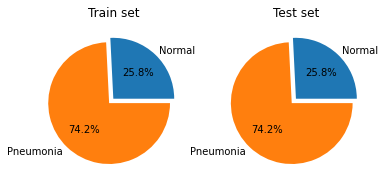

<Figure size 432x288 with 0 Axes>

In [5]:
# 2

classes_train1 = data_train1.targets
classes_test1 = data_test1.targets

pneumonia_train=int(sum(classes_train1))
normal_train=len(classes_train1)-pneumonia_train


pneumonia_test=int(sum(classes_test1))
normal_test=len(classes_test1)-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train, pneumonia_train]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')


plt.show()
plt.savefig('distribucionTrainTest.png')

In [6]:
# 3

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
#data_train = Subset(data_train1, train_idx)
#data_val   = Subset(data_train1,val_idx)

class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        self.indices_val      = indices_val
        #self.etiquetas_val    = etiquetas_val
        self.prob_pneumonia   = sum(etiquetas_prueba)/len(etiquetas_prueba)
        self.prob_normal      = 1-self.prob_pneumonia
        self.prob_vector      = [ int((etiquetas_val[i]==1 )*self.prob_pneumonia+
                                 (etiquetas_val[i]==0)*self.prob_normal)
                                for i in range(len(etiquetas_val))
                                ]
    def __iter__(self):
        return iter(np.random.choice(self.indices_val,p=self.prob_vector))
    
etiquetas_prueba = data_test1.targets
# indices_val = val_idx
etiquetas_val = [data_train1.targets[i] for i in val_idx ] 

a=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val)

In [7]:
# 4
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler

data_train = DataLoader(data_train1,sampler=SubsetRandomSampler(train_idx))
data_val   = DataLoader(data_train1,sampler=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val))
data_test  = DataLoader(data_test1,sampler=RandomSampler(data_test1))

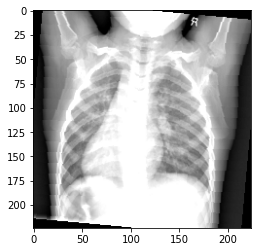

In [8]:
tensor_image = data_train1[0][0].permute(1, 2, 0)
import matplotlib.pyplot as plt
plt.imshow(tensor_image)

# P2

In [9]:

#1 
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020)


class DWSepConv2d(nn.Module):
    
    def __init__(self,in_channels, out_channels, kernel_size,padding,bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size,padding=padding,bias=bias)
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=1,padding=padding,bias=bias)
    def forward(self,xb):
        xb = F.relu(self.conv1(xb.float()))
        xb = F.relu(self.conv2(xb)) 
        return xb

In [70]:
#2
import torchvision

class VGG16DWSep(nn.Module):
    
    def __init__(self,in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) # verificar los tamaños
        self.dwconv3 = DWSepConv2d(64,128,kernel_size=3,padding=1)
        self.dwconv4 = DWSepConv2d(128,128,kernel_size=3,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dwconv5 = DWSepConv2d(128,256,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.dwconv6 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.dwconv7 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dwconv8 = DWSepConv2d(256,512,kernel_size=3,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.dwconv9 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dwconv10 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(739328,1024)
        self.drop1 = nn.Dropout(.7)
        self.lin2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(.5)
        self.lin3 = nn.Linear(512,2)
    
    def forward(self,xb):
        xb = xb.view(-1,3,224,224)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = self.maxpool1(xb)
        xb = F.relu(self.dwconv3(xb))
        xb = F.relu(self.dwconv4(xb))
        xb = self.maxpool2(xb)
        xb = F.relu(self.dwconv5(xb))
        xb = F.relu(self.batchnorm1(xb))
        xb = F.relu(self.dwconv6(xb))
        xb = F.relu(self.batchnorm2(xb))
        xb = F.relu(self.dwconv7(xb))
        xb = self.maxpool3(xb)
        xb = F.relu(self.dwconv8(xb))
        xb = F.relu(self.batchnorm3(xb))
        xb = F.relu(self.dwconv9(xb))
        xb = F.relu(self.batchnorm4(xb))
        xb = F.relu(self.dwconv10(xb))
        xb = F.relu(self.flatten1(xb))
        xb = F.relu(self.lin1(xb))
        xb = self.drop1(xb)
        xb = F.relu(self.lin2(xb))
        xb = self.drop2(xb)
        xb = F.relu(self.lin3(xb))

In [71]:
# Descargamos la red vgg16
vgg16 = torchvision.models.vgg16(pretrained=True, progress=True)

In [72]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')

In [73]:

from torchsummary import summary
summary(vgg16.cuda(),(3,224,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 244]           1,792
              ReLU-2         [-1, 64, 224, 244]               0
            Conv2d-3         [-1, 64, 224, 244]          36,928
              ReLU-4         [-1, 64, 224, 244]               0
         MaxPool2d-5         [-1, 64, 112, 122]               0
            Conv2d-6        [-1, 128, 112, 122]          73,856
              ReLU-7        [-1, 128, 112, 122]               0
            Conv2d-8        [-1, 128, 112, 122]         147,584
              ReLU-9        [-1, 128, 112, 122]               0
        MaxPool2d-10          [-1, 128, 56, 61]               0
           Conv2d-11          [-1, 256, 56, 61]         295,168
             ReLU-12          [-1, 256, 56, 61]               0
           Conv2d-13          [-1, 256, 56, 61]         590,080
             ReLU-14          [-1, 256,

In [74]:

# Se deben obtener las dos primeras capas de convolucion de la red VGG16
for i in range(3):
  print(vgg16.features[i])

# Se quiere la capa 0 y la 2, que son las dos primeras convolucionales:
pesos_dict = {
    'conv1' : vgg16.features[0],
    'conv2' : vgg16.features[2]
}

net = VGG16DWSep(in_channels = 3)


#intento de traspaso de pesos:
net.conv1.weight = pesos_dict['conv1'].weight
net.conv2.weight = pesos_dict['conv2'].weight

# Congelamos los pesos de las dos primeras capas convoluvionales de la red 
# (capas que se transfirieron):
net.conv1.requires_grad_ = False
net.conv2.requires_grad_ = False


# Congelamos los pesos de la red vgg16
for param in vgg16.parameters():
  param.requires_grad = False

# Clase EarlyStopping
# Se requiere la libreria numpy!!
import numpy  as np
class EarlyStopping():
  '''
  Regularization heuristic:

  '''
  def __init__(self, modo='min', paciencia=5, porcentaje:bool = False, tol=0):
    '''
    Arguments:
    ---------
    modo: 'min' o 'max'. Si se debe minimizar o maximizar la metrica objetivo
    paciancia: Cantidad de epocas en la que la metrica puede empeorar
    porcentaje: si la diferencia es relativa (true) o absoluta
    tol: diferencia minima que debe existir con respecto la mejor metrica ya
        observada  para considerar si existe un empeoramiento del desempeno
    '''
    self.modo = modo
    self.paciencia  = paciencia
    self.porcentaje = porcentaje
    self.best = np.Inf if self.modo == 'min' else -np.Inf
    self.contador = 0
    self.tol = tol

  
  def __compareMin(self, metrica_validacion):
    if self.porcentaje:      
      # Si la dif relativa es mayor a la tolerada: actualizar contador:
      if metrica_validacion < (1-self.tol)*self.best:
        self.contador = 0
        self.best = metrica_validacion
        return True
      else:
        self.contador +=1
        return False
    else:
      if metrica_validacion < self.best - self.tol:
        self.best = metrica_validacion
        self.contador = 0
        return True
      else:
        self.contador += 1
        return False
    
    def __comareMax(self, metrica_validacion):
      if self.porcentaje:
         # Si la dif relativa es mayor a la tolerada: actualizar contador:
        if metrica_validacion > (1+self.tol)*self.best:
          self.contador = 0
          self.best = metrica_validacion
          return True
        else:
          self.contador +=1
          return False
      else:
        if metrica_validacion > self.best + self.tol:
          self.best = metrica_validacion
          self.contador = 0
          return True
        else:
          self.contador += 1
          return False        

  # Es necesaria la anotacion??
  #@classmethod
  def __mejor(self, metrica_validacion):
    '''
    Compara @metrica_validacion con la mejor ya observada segun las 
    especificaciones de porcentaje y modo. 
    '''
    if self.modo == 'min':
      # Comparar segun el modo y porcentaje:
      if self.__compareMin(metrica_validacion):
        return True
      else:
        return False
    else:
      # Comparar segun el modo y porcentaje:
      if self.__compareMax(metrica_validacion):
        return True
      else:
        return False

  #@classmethod
  def deberia_parar(self, metrica_validacion):
    if not self.__mejor(metrica_validacion) and self.contador >= self.paciencia:
      return True
    else:
      return False

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [75]:
#Ciclo de entrenamiento:
#en cpu
from torch import optim
from torch.autograd import Variable

opt = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

es = EarlyStopping()
epochs = 20
net.cuda()
for epoch in range(1, epochs+1):
  net.train()
  for batch_idx, (data, target) in enumerate(data_train):
    data, target = Variable(data.cuda()), Variable(target.cuda())
    opt.zero_grad()
    output = net(data)
    loss = loss_func(output, target, weight=weights)
    loss.backward()
    opt.step()
    
    losses[iter_] = loss.data[0]
    mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

TypeError: ignored

# P3

In [ ]:
#1

# librerías usadas
import torch
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# iniciar datos
def load(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb



# transformaciones compose
transformers=transforms.Compose([transforms.Resize([229,229]),
                transforms.CenterCrop(229),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225], inplace = True)
                ])

In [ ]:
# 2
from keras.applications.imagenet_utils import decode_predictions
inception_v3_net = models.inception_v3(pretrained=True)

In [ ]:
inception_v3_net.eval()
filename = 'dog.jpg'
input_image = Image.open(filename)
input_tensor = transformers(input_image).float()
input_batch = input_tensor.unsqueeze(0)
inception_v3_net(input_batch)